<a href="https://colab.research.google.com/github/hayashiyus/First-steps-towards-Deep-Learning/blob/main/51_Optimization_methods.ipynb" target="_parent">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#@title install packages
!pip install mplcyberpunk
!pip install watermark

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import mplcyberpunk

In [3]:
import re
import os
import PIL
import copy
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <2DA9257B-4A11-392E-A85D-FE9CA74E0785> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### **0.　準備**
データ正規化，データ拡張を実装するために，ベースとなる画像データを準備します．

In [6]:
batch_size = 8

# データ加工無
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transforms.ToTensor())
# データ加工無
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

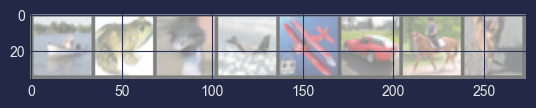

ship  frog  bird  plane plane car   horse dog  


In [8]:
# データ加工無
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
plt.style.use("cyberpunk")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### **1.　データ正規化**

##### **問1：データ正規化**
以下のPyTorch公式チュートリアルを参考に画像のデータ正規化を実装してください．<br>
https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

##### **例1**

In [20]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(32, 32)),
    torchvision.transforms.Normalize(mean=[0.5125,0.4667,0.4110], std=[0.2621,0.2501,0.2453]),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(32, 32)),
    torchvision.transforms.Normalize(mean=[0.5125,0.4667,0.4110], std=[0.2621,0.2501,0.2453]),
])

# データ正規化有
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=train_transforms)
# データ正規化有
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=test_transforms)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


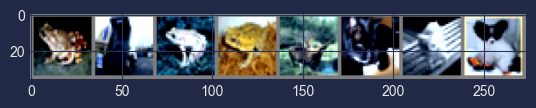

frog  truck frog  frog  deer  cat   cat   dog  


In [21]:
# データ正規化有
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
plt.style.use("cyberpunk")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### **2.　データ拡張**

##### **問2：データ拡張**
以下のPyTorch公式チュートリアルを参考に画像のデータ拡張を実装してください．<br>
https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

##### **例2**

In [24]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(32, 32)),
    torchvision.transforms.RandomCrop(size=(28, 28)),
    torchvision.transforms.RandomRotation(degrees=30, interpolation=PIL.Image.BILINEAR),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(32, 32)),
    torchvision.transforms.CenterCrop(size=(28, 28)),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# データ拡張有
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=train_transforms)
# データ拡張有
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=test_transforms)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


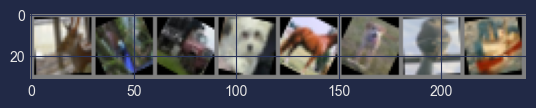

deer  bird  truck dog   horse dog   bird  ship 


In [25]:
# データ拡張有
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
plt.style.use("cyberpunk")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
%load_ext watermark
%watermark --iversions

mplcyberpunk: 0.6.0
numpy       : 1.22.4
PIL         : 9.2.0
matplotlib  : 3.6.0
torchvision : 0.13.1
torch       : 1.13.0
re          : 2.2.1
pandas      : 1.5.0

